# Analyse décès sur le territoire Français

Une analyse des impacts globaux du covid en s'abstrayant des biais de tests

In [47]:
# Generic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, datetime, timedelta

In [48]:
debug = True
histo_2020=True

In [49]:
t0 = datetime.now()

## Recent data crunching

In [50]:
# Data from insee
# https://insee.fr/fr/statistiques/4487988?sommaire=4487854 
insee_file = "2021-02-05_deces_quotidiens_departement_csv.csv"
df_insee = pd.read_csv("./Data_FR_Deaths/" + insee_file, delimiter=";", index_col="Date_evenement", encoding='iso-8859-1')
df_insee.drop(["Communes_a_envoi_dematerialise_Deces2019","Total_deces_2019"],axis=1,inplace=True)
df_insee

,Zone,Communes_a_envoi_dematerialise_Deces2021,Total_deces_2021,Communes_a_envoi_dematerialise_Deces2020,Total_deces_2020
Date_evenement,,,,,
01-janv.,France,1922.0,2110.0,1734,1900
02-janv.,France,3761.0,4142.0,3478,3795
03-janv.,France,5696.0,6268.0,5254,5744
04-janv.,France,7650.0,8433.0,6907,7569
05-janv.,France,9610.0,10576.0,8477,9304
...,...,...,...,...,...
27-déc.,Dept_976,NaN,NaN,923,923
28-déc.,Dept_976,NaN,NaN,923,923
29-déc.,Dept_976,NaN,NaN,925,925


In [51]:
df_insee.index.str[-8:].unique()

Index(['01-janv.', '02-janv.', '03-janv.', '04-janv.', '05-janv.', '06-janv.',
       '07-janv.', '08-janv.', '09-janv.', '10-janv.',
       ...
       '22-déc.', '23-déc.', '24-déc.', '25-déc.', '26-déc.', '27-déc.',
       '28-déc.', '29-déc.', '30-déc.', '31-déc.'],
      dtype='object', name='Date_evenement', length=366)

In [52]:
# change in date format 
df_insee.reset_index(inplace=True)

replace_list = [('-janv.','/01/2021'),('-févr.','/02/2021'),('-mar.','/03/2021'),('-avr.','/04/2021'),('-mai','/05/2021'),('-juin','/06/2021'),('-juil.','/07/2021'),
                ('-août','/08/2021'),('-sept.','/09/2021'),('-oct.','/10/2021'),('-nov.','/11/2021'),('-déc.','/12/2021')]
for m, r in replace_list:
    df_insee['Date_evenement'].replace(to_replace=m, value = r, regex = True, inplace=True)

df_insee.set_index('Date_evenement', inplace=True)

### Vérification de l'intégrité des sommes

In [53]:
df_insee

,Zone,Communes_a_envoi_dematerialise_Deces2021,Total_deces_2021,Communes_a_envoi_dematerialise_Deces2020,Total_deces_2020
Date_evenement,,,,,
01/01/2021,France,1922.0,2110.0,1734,1900
02/01/2021,France,3761.0,4142.0,3478,3795
03/01/2021,France,5696.0,6268.0,5254,5744
04/01/2021,France,7650.0,8433.0,6907,7569
05/01/2021,France,9610.0,10576.0,8477,9304
...,...,...,...,...,...
27/12/2021,Dept_976,NaN,NaN,923,923
28/12/2021,Dept_976,NaN,NaN,923,923
29/12/2021,Dept_976,NaN,NaN,925,925


In [54]:
check = df_insee[df_insee.loc[:,"Zone"]=="France"]
check_sum = df_insee[df_insee.loc[:,"Zone"]!="France"].groupby('Date_evenement').sum()

In [55]:
check_3 = check.join(check_sum, rsuffix="_sum",)[["Total_deces_2020", "Total_deces_2020_sum"]]

In [56]:
(check_3["Total_deces_2020"]-check_3["Total_deces_2020_sum"]).describe()

count    366.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

### filtrage et reformation du df insee

In [57]:
df_insee = df_insee[df_insee["Zone"]=="France"][["Total_deces_2020","Total_deces_2021"]]

In [58]:
df_insee.sort_index(axis=1,inplace=True)
df_insee.columns = [2020, 2021]

In [59]:
df_insee.loc["29/02/2021",:]

2020    108760.0
2021         NaN
Name: 29/02/2021, dtype: float64

## 2021

In [60]:
# mock data
# #########
# charged from 2020 data.
#df_2021 = pd.read_csv("Data_FR_Deaths/deces_2020.csv", index_col=0, parse_dates=[0])
#df_2021.columns = pd.to_numeric(df_2021.columns)
#min_21, max_21 = df_2021.min(), df_2021.max()

In [61]:
#def randomization(v, mn, mx):
#    return v + np.random.rand() * (mx-mn)*0.1
#def randomize(v):
#    return randomization(v, min_21, max_21)

In [62]:
#df_2021 = df_2021.apply(randomize, axis=1)
#df_2021 = df_2021[:-1]
#df_2021.columns=[2021]
#df_2021.index = pd.date_range("2021-01-01", "2021-12-31")
# selection 3 premiers mois
#deb_2021 = pd.date_range("2021-01-01", "2021-02-28")
#df_2021 = df_2021.loc[deb_2021]

In [63]:
df_2021 = pd.DataFrame(df_insee[2021])
df_2021.drop("29/02/2021", inplace=True)


In [64]:
df_2021 = df_2021.diff()


In [65]:
df_2021.loc["01/01/2021",2021]=df_insee.loc["01/01/2021",2021]

In [66]:
df_2021.index = pd.to_datetime(df_2021.index, dayfirst=True)

In [67]:
df_2021

,2021
Date_evenement,
2021-01-01,2110.0
2021-01-02,2032.0
2021-01-03,2126.0
2021-01-04,2165.0
2021-01-05,2143.0
...,...
2021-12-27,NaN
2021-12-28,NaN
2021-12-29,NaN




## 2020 

In [68]:
if not histo_2020:
    df_2020 = df_insee.diff()
    #filtre avant mars (input historique)
    #df_2020 = df_insee.filter(axis=0,regex="\d\d\/(0[3-9]|1[0-2])").diff()
    df_2020.index = pd.to_datetime(df_2020.index, dayfirst=True)
    df_2020.columns = [2020]
    # first date is unkown as diff cannot be applied on first element
    #pour première données en janvier
    df_2020.loc["2020/01/01",:]=df_insee.loc["01/01/2020",:]
    # enregistrement 2020
    df_2020.to_csv("Data_FR_Deaths/deces_2020.csv")
else:
    #lecture depuis historique
    df_2020 = pd.read_csv("Data_FR_Deaths/deces_2020.csv", index_col=0, parse_dates=[0])
    df_2020.columns = pd.to_numeric(df_2020.columns)
df_2020 

,2020
Date_evenement,
2020-01-01,1900.0
2020-01-02,1895.0
2020-01-03,1949.0
2020-01-04,1824.0
2020-01-05,1735.0
...,...
2020-12-27,1988.0
2020-12-28,2103.0
2020-12-29,1984.0


In [69]:
#df_2020.loc["2020-02-28", 2020] = df_2020.loc["2020-02-29",2020] + df_2020.loc["2020-02-28",2020]
#df_2020.drop(pd.Timestamp("2020-02-29"))

In [70]:
type(df_2020.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [71]:
df_2020.loc["2020-02-29",:]

2020    1715.0
Name: 2020-02-29 00:00:00, dtype: float64

## Données de références (2000 à 2019)

In [72]:
# données historiques
df_histo_csv = pd.read_csv("./Data_FR_Deaths/" + 'histo_deces.csv', index_col = 0)
# remove badly formatted data and before 2000
df_histo_csv = df_histo_csv.filter(regex = '2[0-9]{3}\-[0-1][0-9]\-[0-3][0-9]', axis=0)
# transform index into dates
#df_histo_csv.index = pd.to_datetime(df_histo_csv.index, format = "%Y-%m-%d")
df_histo_csv.index = pd.DatetimeIndex(df_histo_csv.index)
# Add info for reference
df_histo_csv.reset_index(inplace=True)



In [73]:
df_histo_csv.sort_values(by="date_deces").tail()

,date_deces,nbr_deces
7390,2020-03-26,1647
7391,2020-03-27,1178
7392,2020-03-28,853
7393,2020-03-29,559
7394,2020-03-30,179


### Data for 2020, 2021 and references

In [74]:
#import datetime
base = datetime.fromisoformat("2021-01-01")
date_list = [base + timedelta(days=x) for x in range(365)]

In [75]:
df_histo = pd.DataFrame(date_list)
df_histo.columns = ['date_ref']
df_histo['year'] = pd.DatetimeIndex(df_histo['date_ref']).year
#df_histo['week'] = pd.DatetimeIndex(df_histo['date_ref']).weekofyear
df_histo['week'] = pd.DatetimeIndex(df_histo['date_ref']).isocalendar().week
df_histo['dow'] = pd.DatetimeIndex(df_histo['date_ref']).weekday  + 1
#df_histo['ref'] = df_histo['week'].astype('str') + "-" + df_histo['dow'].astype('str')
df_histo['ref'] = df_histo['date_ref'] 

In [76]:
lst_years = range(2019,1999,-1)

In [77]:
# traitement pour 2020
df_histo['ref'] = df_histo['ref'] - pd.Timedelta(days=364)
df_histo = df_histo.join(df_2020, on=['ref'],rsuffix='_'+str(2020), how='left')

In [78]:
# Join the references same dow last year (-364d)
for x in lst_years:
    df_histo['ref'] = df_histo['ref'] - pd.Timedelta(days=364)
    df_histo = df_histo.join(df_histo_csv.set_index('date_deces'), on=['ref'],rsuffix='_'+str(x), how='left')

In [79]:
df_histo.drop(['year','week','dow','ref'], axis=1, inplace=True)
df_histo.set_index('date_ref',inplace=True)
df_histo.columns = [2020]+  list(lst_years)
#df_histo.columns = list(lst_years)

In [80]:
# min max sur 2000-2019 seulement
df_histo['max'] = df_histo[lst_years].max(axis=1)
df_histo['min'] = df_histo[lst_years].min(axis=1)

In [81]:
df_histo

,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,...,2007,2006,2005,2004,2003,2002,2001,2000,max,min
date_ref,,,,,,,,,,,,,,,,,,,,,
2021-01-01,1949.0,1900,2102,2260,1721,1965,1699,1777,1692,1714,...,1579,1602,1573,1561,1556,1856,1633,1979,2260,1556
2021-01-02,1824.0,1921,2020,2239,1741,1936,1693,1793,1648,1725,...,1600,1548,1668,1633,1632,1851,1625,1975,2239,1548
2021-01-03,1735.0,1896,2008,2228,1745,1903,1562,1675,1642,1633,...,1446,1599,1533,1541,1572,1788,1633,1995,2228,1446
2021-01-04,1975.0,1983,2072,2379,1834,1941,1755,1788,1738,1727,...,1536,1598,1651,1673,1734,1830,1502,1946,2379,1502
2021-01-05,1987.0,1965,2060,2420,1753,1937,1725,1848,1820,1658,...,1534,1573,1629,1619,1590,1733,1658,2081,2420,1534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2103.0,1892,1890,2027,2371,1835,1978,1786,1787,1736,...,1722,1658,1577,1652,1614,1851,1916,1764,2371,1577
2021-12-28,1984.0,1800,1839,2142,2353,1778,1848,1781,1803,1776,...,1803,1557,1734,1619,1675,1774,1852,1646,2353,1557
2021-12-29,1956.0,1905,1935,2137,2251,1799,1969,1686,1742,1686,...,1713,1665,1665,1604,1702,1706,1830,1728,2251,1604


In [82]:
df_histo_moyenne = df_histo[lst_years].mean(axis=1)

In [83]:
df_histo_moyenne

date_ref
2021-01-01    1780.10
2021-01-02    1777.60
2021-01-03    1734.35
2021-01-04    1809.15
2021-01-05    1799.20
               ...   
2021-12-27    1832.50
2021-12-28    1824.45
2021-12-29    1813.80
2021-12-30    1792.00
2021-12-31    1778.85
Length: 365, dtype: float64

### Data frame principal

In [84]:
derniere_photo = df_2021.dropna().index.max().date()
print(f"Dernière date trouvée : {derniere_photo}")

Dernière date trouvée : 2021-01-25


## Comparaison décès par jour 2021 vs références

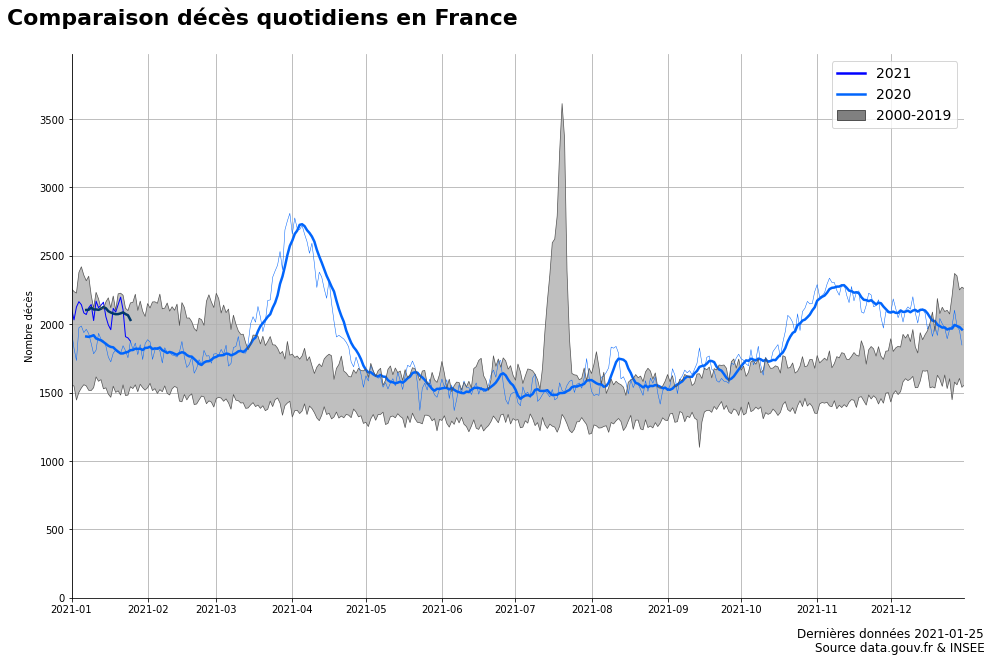

In [85]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Figure et axe principaux
# ########################
fig, ax = plt.subplots(figsize=(16,10))

# courbe 2021
# ###########
ax.plot(df_2021, label='2021', linewidth=1, color='blue')
# moyenne mobile
ax.plot(df_2021.rolling(7).mean(), label='2021 Moyenne mobile 7', linewidth=2.5, color='xkcd:marine blue' )

# courbe 2020
# moyenne mobile
ax.plot(df_histo[2020].rolling(7).mean(), label='2020 Moyenne mobile 7', linewidth=2.5, color='xkcd:bright blue' )
ax.plot(df_histo[2020], label='2020 Moyenne mobile 7', linewidth=0.5, color='xkcd:bright blue' )

# defining area of reference
# ##########################

# Boundaries
ax.plot(df_histo[['min','max']], label='2000-2019', color="#525252",linewidth=0.7 )
# moyenne
#ax.plot(df_histo_moyenne.rolling(7).mean(), label="Moyenne 2020*2019", color="#78787a", linewidth=1.5)

# fill
ax.fill_between(date_list, df_histo['min'], df_histo['max'], facecolor='grey', alpha=0.5)


# layout
ax.set_title("Comparaison décès quotidiens en France", fontsize=22, pad=30, fontweight = 'bold',horizontalalignment='right')
#ax.set_xlabel("date du jour")
ax.set_ylabel("Nombre décès")
ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.margins(0.05)
ax.set_xlim([pd.to_datetime('2021-01-01'),pd.to_datetime('2021-12-31')])
ax.set_ylim(0, max(df_2021.max()[2021], df_histo.max().max())*1.1)
# define legend
# #############
legend_elements = [#Line2D([0], [0], color='blue', lw=1, label='2021'),
                   Line2D([0], [0], color='blue', lw=2.5, label='2021'),
                   Line2D([0], [0], color='xkcd:bright blue', lw=2.5, label='2020'),
                   Patch(facecolor='grey', edgecolor='#525252',
                         label='2000-2019'),
                   #Line2D([0], [0], color='#78787a', lw=1, label='2000-2019 moyenne mobile 7j'),
                  ]
ax.legend(handles=legend_elements, fontsize=14)

fig.text(0.77, 0.05, "Source data.gouv.fr & INSEE", fontsize=12)
fig.text(0.755, 0.07, f"Dernières données {derniere_photo}", fontsize=12)


# Commentaires
#ax.annotate("Canicule 2003", xy=(0.56, 0.9), xytext=(0.65, 0.7), xycoords = "axes fraction",
#            arrowprops={"width":3,"edgecolor":"lightgrey", "facecolor":"lightgrey"}, fontsize=14, )



#arrowprops=dict(arrowstyle="->", width=4)
fig.savefig("deces_fr_v2-"+ str(date.today()) +".png")


# Comparaison journalière (en polaire)

In [86]:
import datetime
def date_formater(t):
    return datetime.datetime.fromtimestamp(t).strftime("%Y-%m")
    #return t

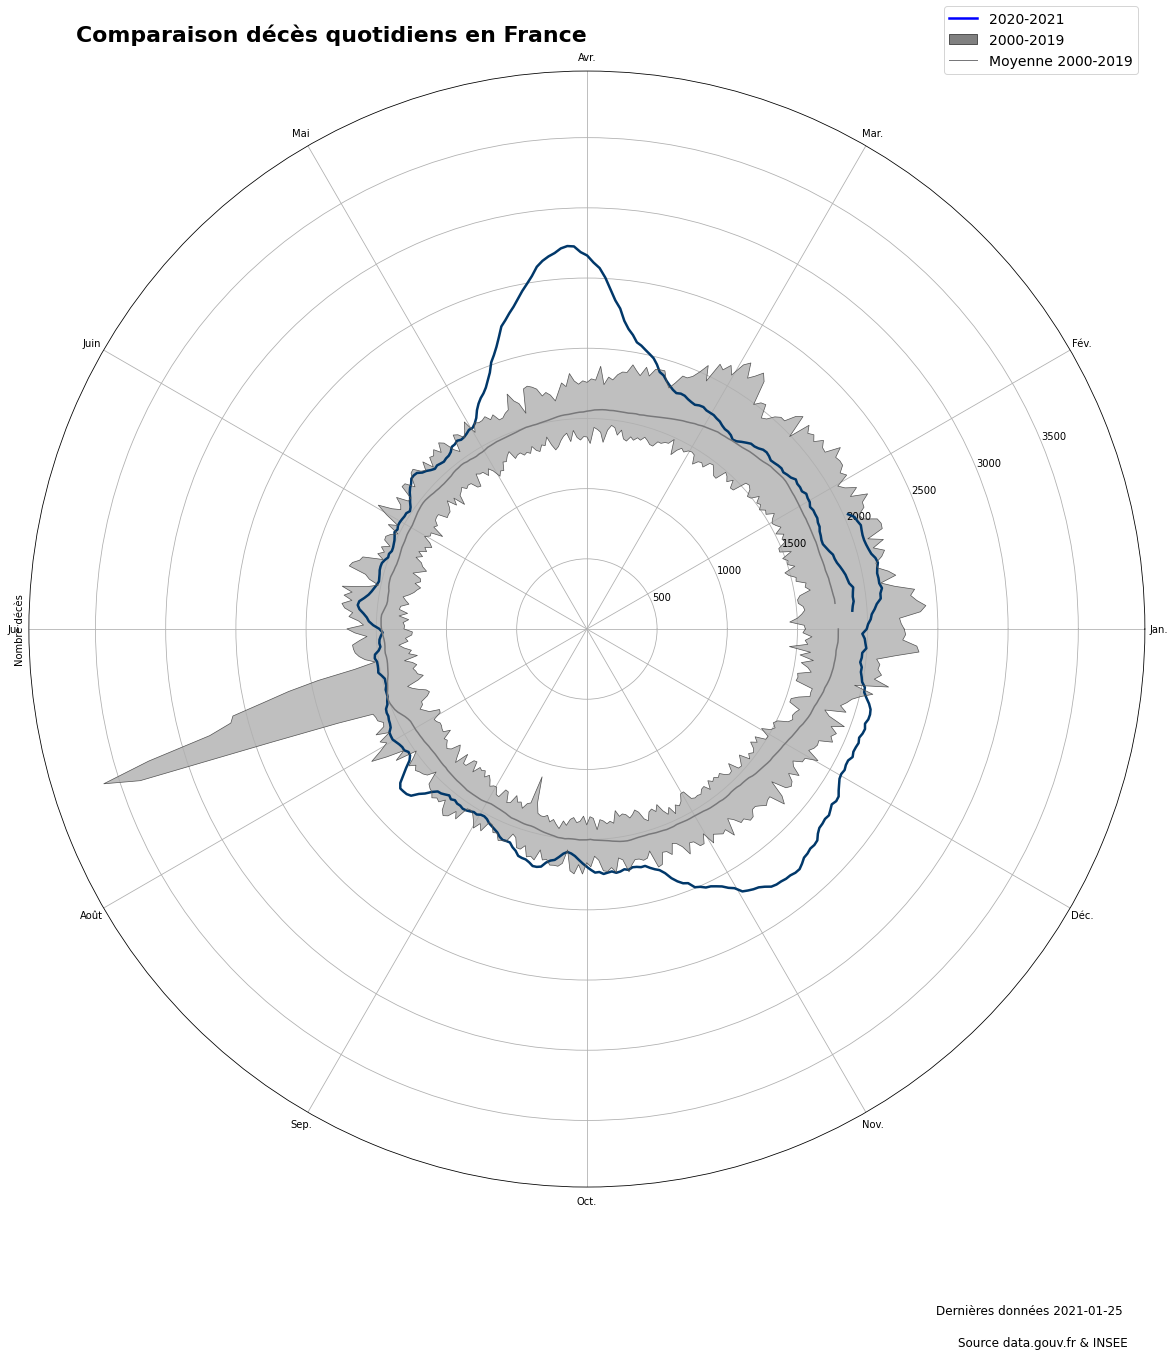

In [87]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# Figure et axe principaux
# ########################
fig, ax = plt.subplots(figsize=(20,22),  subplot_kw=dict(projection='polar'))


#Y représente la concatenation 2020-2021
df_tmp = df_2020.copy()
df_tmp.columns = [2021]
y = df_2021.append(df_tmp).sort_index()
y_2021 = y[2021]


# transformation date en radian
# #############################
#t = mdates.date2num(df_histo.index)
t = df_histo.reset_index()['date_ref'].apply(datetime.datetime.timestamp)
t_2021 = y.reset_index()['Date_evenement'].apply(datetime.datetime.timestamp)
#t_2021 = mdates.date2num(y.index)

t_min, t_max = t.min(), t.max()
# for reference normalisation
tnorm = (t-t_min)/(t_max-t_min)*2.*np.pi
# for normalisation of actuals
tnorm_2021 = (t_2021-t_min)/(t_max-t_min)*2.*np.pi



# courbe 2021
# ###########
#ax.plot(tnorm_2021, y_2021, label='2021', linewidth=1, color='blue')
# moyenne mobile
ax.plot(tnorm_2021, y_2021.rolling(7).mean(), label='2020 Moyenne mobile 7', linewidth=2.5, color='xkcd:marine blue' )


# defining area of reference
# ##########################

# Boundaries
ax.plot(tnorm, df_histo[['min','max']], label='2000-2019', color="#525252",linewidth=0.7 )
# moyenne
ax.plot(tnorm, df_histo_moyenne.rolling(7).mean(), label="Moyenne 2020*2019", color="#78787a", linewidth=1.5)

# fill
ax.fill_between(tnorm, df_histo['min'], df_histo['max'], facecolor='grey', alpha=0.5)


# layout
# ######


ax.set_title("Comparaison décès quotidiens en France", fontsize=22, pad=30, fontweight = 'bold',horizontalalignment='right')
#ax.set_xlabel("date du jour")
ax.set_ylabel("Nombre décès")
ax.grid(True)
ax.margins(0.05)
ax.set_ylim(0, max(df_2021.max()[2021], df_histo.max().max())*1.1)
#arrange les coordonnées pour des mois
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 1/6*np.pi))
#ax.set_xticklabels([f"{date_formater(t*(t_max-t_min)/(2*np.pi) + t_min)}"  for t in ax.get_xticks()])
ax.set_xticklabels(["Jan.","Fév.","Mar.","Avr.","Mai","Juin","Jui.","Août","Sep.","Oct.","Nov.","Déc."])

#locator = ax.xaxis.get_major_locator()
#formatter = mdates.ConciseDateFormatter(locator)
#ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_formatter(formatter)


# define legend
# #############
legend_elements = [
                   Line2D([0], [0], color='blue', lw=2.5, label='2020-2021'),
                   Patch(facecolor='grey', edgecolor='#525252',
                         label='2000-2019'),
                   Line2D([0], [0], color='#78787a', lw=1, label='Moyenne 2000-2019'),
                  ]

fig.legend(handles=legend_elements, fontsize=14, loc='upper right', bbox_to_anchor=(0.9, 0.9))

fig.text(0.77, 0.05, "Source data.gouv.fr & INSEE", fontsize=12)
fig.text(0.755, 0.07, f"Dernières données {derniere_photo}", fontsize=12)


# Commentaires
#ax.annotate("Canicule 2003", xy=(0.56, 0.9), xytext=(0.65, 0.7), xycoords = "axes fraction",
#            arrowprops={"width":3,"edgecolor":"lightgrey", "facecolor":"lightgrey"}, fontsize=14, )



#arrowprops=dict(arrowstyle="->", width=4)
fig.savefig("deces_fr_radar-"+ str(date.today()) +".png")


In [88]:
df_2021.max()[2021]

2198.0

In [89]:
y.reset_index()["Date_evenement"]

0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-05
         ...    
726   2021-12-27
727   2021-12-28
728   2021-12-29
729   2021-12-30
730   2021-12-31
Name: Date_evenement, Length: 731, dtype: datetime64[ns]

In [90]:
y_2021 = pd.DataFrame(y_2021)
y_2021['t'] = tnorm_2021
y_2021.reset_index().set_index('t')

,Date_evenement,2021
t,,
NaN,2020-01-01,1900.0
NaN,2020-01-02,1895.0
NaN,2020-01-03,1949.0
NaN,2020-01-04,1824.0
NaN,2020-01-05,1735.0
...,...,...
NaN,2021-12-27,NaN
NaN,2021-12-28,NaN
NaN,2021-12-29,NaN


In [91]:
tnorm_2021

0     -6.317708
1     -6.300447
2     -6.283185
3     -6.265924
4     -6.248662
         ...   
726    6.214139
727    6.231401
728    6.248662
729    6.265924
730    6.283185
Name: Date_evenement, Length: 731, dtype: float64

# Cumul des décès cumulés

In [92]:
# Calculs des cumuls

data_cum_2020 = df_wp.cumsum()
data_cum_2000_2019 = df_histo.mean(axis=1).cumsum()

derniere_augmentation_cum = data_cum_2020.max().values[0] / data_cum_2000_2019[data_cum_2020.idxmax()].values[0] - 1

augmentation_cum = data_cum_2020.join(pd.DataFrame(data_cum_2000_2019))
augmentation_cum.fillna(0)
augmentation_cum.columns = ['2020', 'ref']
augmentation_cum['evol'] = augmentation_cum['2020'] - augmentation_cum['ref'] 



NameError: name 'df_wp' is not defined

In [ ]:
augmentation_cum['2020'].idxmax()

In [ ]:
def position_fleche(ax, pourcentages, last_pct):
    
    x_max = pourcentages['2020'].idxmax()
    share_of_year = (x_max - pd.to_datetime("2020-01-01")).days/365 
    dernier_pourcentage = last_pct
    y_last = pourcentages.loc[x_max, 'evol']
   
    y_min, y_max = min(ax.get_yticks()), max(ax.get_yticks())
    
    y_fleche = (y_last - y_min ) / (y_max - y_min)
    print(y_fleche, y_max)
    ax.annotate(f"{dernier_pourcentage*100:+.1f}%", xy=(share_of_year , y_fleche + 0.02), xytext=(max(min(share_of_year+0.1,0.8),0.2), max(min(y_fleche+0.1,0.8),0.2)), xycoords = "axes fraction",
            arrowprops={"width":3, "edgecolor":"blue", "facecolor":"blue"}, fontsize=14)


In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Figure et axe principaux
# ########################
fig_cum, ax_cum = plt.subplots(figsize=(16,10))


# evolution vs ref
ax_cum.plot(augmentation_cum['evol'], label='2020', linewidth=2.5, color='blue')


# layout
ax_cum.set_title("Comparaison décès quotidiens cumulés en France vs 2000-2019", fontsize=22, pad=30, fontweight = 'bold',horizontalalignment='center')
#ax.set_xlabel("date du jour")
ax_cum.set_ylabel("Evolution cumulée des décès 2021 vs moyenne de 2000-2019")
ax_cum.grid(True)
ax_cum.spines['top'].set_visible(False)
ax_cum.spines['right'].set_visible(False)
ax_cum.margins(0.05)
ax_cum.set_xlim([pd.to_datetime('2021-01-01'),pd.to_datetime('2021-12-31')])
ax_cum.set_yticklabels([f"{t:,.0f} ".replace(","," ") for t in ax_cum.get_yticks()])


fig_cum.text(0.755, 0.07, f"Dernières données {derniere_photo}", fontsize=12)
fig_cum.text(0.77, 0.05, "Source data.gouv.fr & INSEE", fontsize=12)


# Commentaires
position_fleche(ax_cum, augmentation_cum, derniere_augmentation_cum)


fig_cum.savefig("deces_cum_fr-2021-"+ str(date.today()) +".png")


In [ ]:
# final processing
t1 = datetime.now()
print(f"Temps passé {t1-t0}")

In [ ]:
data_cum_2000_2019[data_cum_2020.idxmax()].values[0]